In [1]:
import pandas as pd
import numpy as np
from numpy import fliplr
from numpy import flipud
from numpy import array
from pandas.io.json import json_normalize
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import json
import math
import pymongo
from pymongo import MongoClient
import time
np.random.seed(1234)

def connect_database():
 
    client = MongoClient('localhost', 27017)
    db = client['bitcoin']
    collection = db['final_data2']
    return db, collection

def data_extraction(filed, collection):
    '''
    extract a certain filed('close') of data from the collecttion 
    '''

    data = []
    for doc in list(collection.find())[-10300:-300]:
        data.append(doc[filed])
    data = array(data)
    #data = flipud(data)
    return data

    

def feature_engineering(df):
    """
    preprocess data for better result
    :return:
    """
def take_by_window(dataset, stm, window):
    x, y = [], []
    for i in range(len(dataset) - window ):
        tmp = []
        tmp = np.append(dataset[i:(i + window)], stm[i+window])
        
        x.append(list(tmp))
        y.append(dataset[i + window,])
    x = np.array(x)
    print(x.shape)
    y = np.array(y)
    print(x.shape[0],x.shape[1])
    x = np.reshape(x, (x.shape[0] ,1 , x.shape[1]))
    print(x.shape)
    return x, y

def pred_model(stm, test, x_train, y_train, step_size=1, num_features=3, epochs=100, batch_size=128, verbose=2, pred_num=1000):
    """
    ML model: LSTM
    Look_back: how many point
    :return:
    """

    model = Sequential()
    model.add(LSTM(250, input_shape=(step_size, num_features), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(200))
    model.add(Dense(1))  # output file size
    model.add(Activation('tanh'))  # active function
#     model.add(Dropout(0.05))  # drop out regulation
    model.compile(loss='mse', optimizer='adam')
    model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)
    
    
    
    #pred_feature = x_train[-1]
    #print(pred_feature.shape)
    #print(type(pred_feature))
    #pred_feature = np.reshape(pred_feature, (1 ,1 , num_features))
    #print(pred_feature.shape)
    #x_test = list([x_train[-1]])
    #pred_num = 1000
    y_test = []
    #x_test = []
    
    for i in range(pred_num):
        if i%10 == 0:
            tmp = stm[i]
            pred_feature = test[i]
            pred_feature = np.reshape(pred_feature, (1 ,1 , num_features))
            pred_data = model.predict(pred_feature)
            print('***', pred_data)
            y_test.append(pred_data)
            pred_feature = np.append(pred_feature[0,0,1:-1], pred_data)
            pred_feature = np.append(pred_feature, tmp)
            pred_feature = np.reshape(pred_feature, (1 ,1 , num_features))
        else:
            pred_data = model.predict(pred_feature)
            print(pred_data)
            y_test.append(pred_data)
            pred_feature = np.append(pred_feature[0,0,1:-1], pred_data)
            pred_feature = np.append(pred_feature, tmp)
            pred_feature = np.reshape(pred_feature, (1 ,1 , num_features))

    pred_train = model.predict(x_train)
    #pred_test = model.predict(x_test)
    #pred_dataset = array(pred_dataset)
    #print(array(x_test).shape, array(y_test).shape)
    
    #score = model.evaluate(array(x_test[0:-1]), y_test, batch_size=128)

    return pred_train , np.reshape(array(y_test), (pred_num))



Using TensorFlow backend.


In [2]:
'''connect to DB: bitcoin and collection: btc'''
np.random.seed(1234)
db, collection = connect_database()
df = data_extraction('close', collection)
t = data_extraction('_id', collection)
stm = data_extraction('mean', collection)
dataset = df.astype('float32')
t = t.astype('int32')
mms = MinMaxScaler(feature_range=(-1, 1))

'''construct a scale based on dataset'''
dataset = mms.fit_transform(dataset)

'''define the size of lookback'''
window = 350

/Users/anwang/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/anwang/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [3]:
'''divide dataset to training set and testing set'''
train_size = int(len(dataset)*0.99)
test_size = len(dataset)-train_size
#test_size = 100
#train_set, test_set = dataset[0:train_size], dataset[train_size:]
#train_stm = stm[0: train_size]
#print(len(train_set),len(test_set),len(dataset))

In [4]:
'''prepare the training data'''
x, y = take_by_window(dataset, stm, window)
x_train, y_train = x[:train_size-window], y[:train_size-window]
x_test, y_test = x[train_size-window:], y[train_size-window:]

(9650, 351)
9650 351
(9650, 1, 351)


In [5]:
'''get the predict data'''
start = time.time()
pred_train, pred_test = pred_model(stm[test_size :], x_test, x_train, y_train, step_size=1, num_features=window+1, epochs=1, batch_size=128, verbose=2, pred_num = test_size)
#print(score)
run = time.time()-start

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Epoch 1/1
6s - loss: 0.0185
*** [[0.83389777]]
[[0.83355963]]
[[0.833439]]
[[0.8326397]]
[[0.8305136]]
[[0.83115834]]
[[0.8289545]]
[[0.829022]]
[[0.8280295]]
[[0.82788867]]
*** [[0.837535]]
[[0.83573943]]
[[0.8362723]]
[[0.8348868]]
[[0.8329249]]
[[0.8316394]]
[[0.8310356]]
[[0.82877827]]
[[0.82846993]]
[[0.82801026]]
*** [[0.8341051]]
[[0.8335206]]
[[0.8330329]]
[[0.8318431]]
[[0.83132285]]
[[0.8296505]]
[[0.8286408]]
[[0.82900965]]
[[0.82728636]]
[[0.82711744]]
*** [[0.83444643]]
[[0.8343945]]
[[0.83241695]]
[[0.83254117]]
[[0.8305039]]
[[0.8295322]]
[[0.82844007]]
[[0.8274388]]
[[0.8269852]]
[[0.8261202]]
*** [[0.8297595]]
[[0.82875854]]
[[0.82679135]]
[[0.8268985]]
[[0.82590824]]
[[0.8251986]]
[[0.82515454]]
[[0.8231442]]
[[0.8221951]]
[[0.8212781]]
*** [[0.8244836]]
[[0.82484907]]
[[0.822372]]
[[0.82238233]]
[[0.82144773]]
[[0.8214519]]

In [6]:
'''inverse the scale'''
pred_train = mms.inverse_transform(pred_train)
y_train = mms.inverse_transform(y_train)
pred_test = mms.inverse_transform(pred_test)
y_test = mms.inverse_transform(y_test)

/Users/anwang/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/anwang/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/anwang/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if yo

In [7]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:] = np.nan
trainPredictPlot[window:len(pred_train) + window] = pred_train[:,0] 

In [8]:
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:] = np.nan
testPredictPlot[len(pred_train) + window:] = pred_test

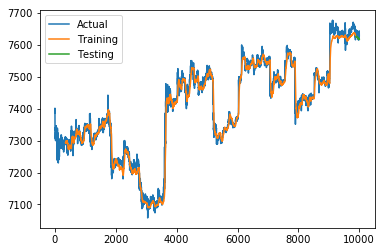

In [9]:
plt.plot(df, label='Actual')
plt.plot(pd.DataFrame(trainPredictPlot, columns=["close"]).close, label='Training')
plt.plot(pd.DataFrame(testPredictPlot, columns=["close"]).close, label='Testing')
plt.legend(loc='best')
plt.show()

In [10]:
tPredictPlot = np.empty_like(dataset)
tPredictPlot[:] = np.nan
tPredictPlot[len(pred_train) + window:] = df[-test_size:]

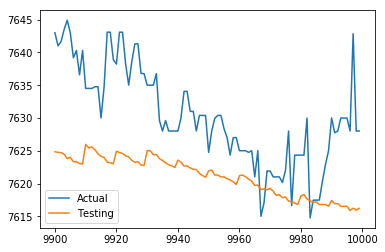

In [11]:
plt.plot(pd.DataFrame(tPredictPlot, columns=["close"]).close, label='Actual')
#plt.plot(pd.DataFrame(trainPredictPlot, columns=["close"]).close, label='Training')
plt.plot(pd.DataFrame(testPredictPlot, columns=["close"]).close, label='Testing')
plt.legend(loc='best')
plt.show()

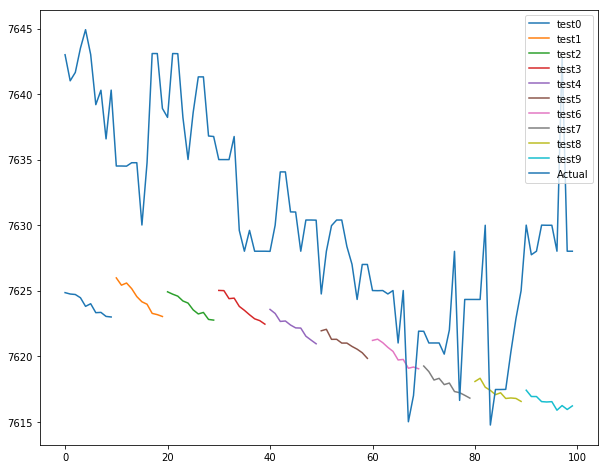

In [12]:
plt.figure(figsize=(10,8))
for i in range(10):
    label = "test"+str(i)
    plt.plot(range(i*10,(i+1)*10),pred_test[i*10:(i+1)*10],label = label)
plt.plot(range(100), df[-test_size:], label = 'Actual')
plt.legend()
plt.show()

In [13]:
"""plt.figure(figsize=(10,8))
for i in range(10):
    label = "test"+str(i)
    plt.plot(range(i*10,(i+1)*10),pred_test[i*4:(i+1)*10],label = label)
plt.plot(range(100), df[-test_size:], label = 'Actual')
plt.legend()
plt.show()"""

'plt.figure(figsize=(10,8))\nfor i in range(10):\n    label = "test"+str(i)\n    plt.plot(range(i*10,(i+1)*10),pred_test[i*4:(i+1)*10],label = label)\nplt.plot(range(100), df[-test_size:], label = \'Actual\')\nplt.legend()\nplt.show()'

In [14]:
trainScore = math.sqrt(mean_squared_error(y_train, pred_train[:, 0]))
print('Train Score: %.2f MSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test, pred_test[:]))
print('Test Score: %.2f MSE' % (testScore))
print(run)

Train Score: 19.50 MSE
Test Score: 10.91 MSE
11.900612115859985


In [15]:
'''count the accuracy rate of prediction based on the price up and down'''
pred = []
true = []
for i in range(0, len(pred_test), 10):
    if pred_test[i+1] >= pred_test[i]:
        pred.append(1)
    else:
        pred.append(0)
    if y_test[i+1] >= y_test[i]:
        true.append(1)
    else:
        true.append(0)
            
accuracy_rate = sum(array(pred) == array(true))/len(true) 

In [16]:
pred = []
true = []
for i in range(len(pred_test)-1):
    if pred_test[i+1] >= pred_test[i]:
        pred.append(1)
    else:
        pred.append(0)
    if y_test[i+1] >= y_test[i]:
        true.append(1)
    else:
        true.append(0)
            
a_r = sum(array(pred) == array(true))/len(true) 

In [17]:
'''save the prediction and time'''

"""coll_test = db['test1']

for i in range(len(pred_test)):
    db.test1.insert_one({'pred_test': float(pred_test[i]), 
                        'time': int(time[len(train_set)] + i*60)
                        })"""

"coll_test = db['test1']\n\nfor i in range(len(pred_test)):\n    db.test1.insert_one({'pred_test': float(pred_test[i]), \n                        'time': int(time[len(train_set)] + i*60)\n                        })"

In [18]:
accuracy_rate

0.5

In [19]:
df[9900:9910]

array([7643.  , 7641.01, 7641.65, 7643.5 , 7644.91, 7643.01, 7639.19,
       7640.29, 7636.58, 7640.3 ])

In [20]:
df[-10:]

array([7630.  , 7627.74, 7628.01, 7630.  , 7629.99, 7629.99, 7628.01,
       7642.85, 7628.01, 7628.01])

In [21]:
pred = []
true = []
for i in range(0, len(pred_test), 10):
    if pred_test[i+5] >= pred_test[i]:
        pred.append(1)
    else:
        pred.append(0)
    if pred_test[i+9] >= pred_test[i+5]:
        pred.append(1)
    else:
        pred.append(0)
        
    if y_test[i+5] >= y_test[i]:
        true.append(1)
    else:
        true.append(0)
    if y_test[i+9] >= y_test[i+5]:
        true.append(1)
    else:
        true.append(0)
    
accuracy_rate2 = sum(array(pred) == array(true))/len(true) 
accuracy_rate2

0.5

In [22]:
pred

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [23]:
true

[1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0]